### Part 1 - Setup

In [1]:
from time import time
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from functions import RANSAC_VP
from functions import convert_homogenous_line
from functions import Angle_btw_vect
from scipy.interpolate import BSpline
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

### Part 2 - Image Pre-processing

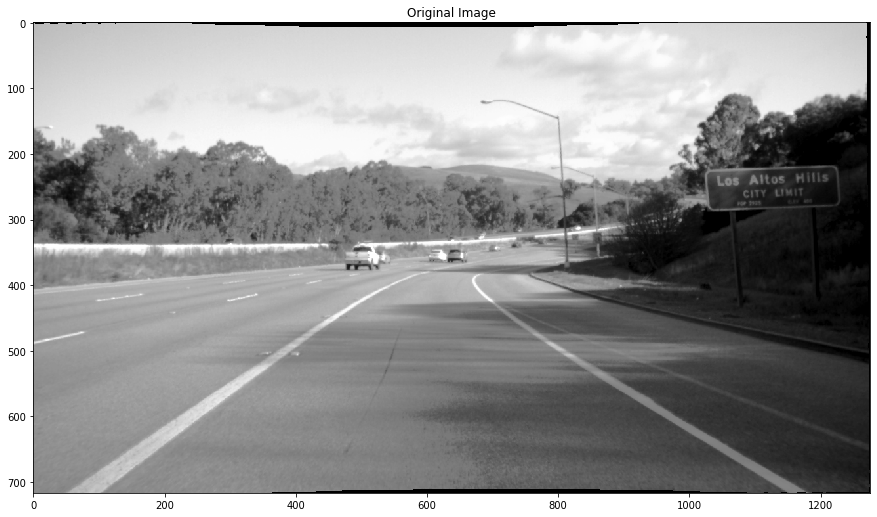

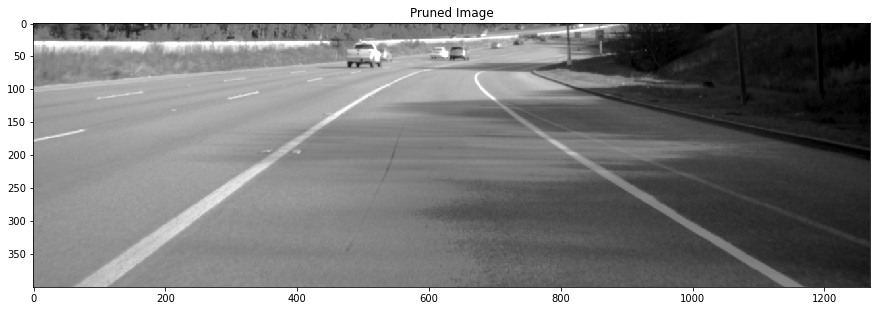

In [2]:
a = 32
file_name = 'TestCase (13).png'
#file_name = './Test/Test'+ str(a)+ '.png' # load test images
img = io.imread(file_name, as_gray=True) # shape = (717,1276)
plt.imshow(img)
plt.title('Original Image')
plt.show()
img_pruned = img[310:710,:1270] # shape = (400,1270)
plt.imshow(img_pruned)
plt.title('Pruned Image')
plt.show()

### Part 3 - Canny Edge Detector

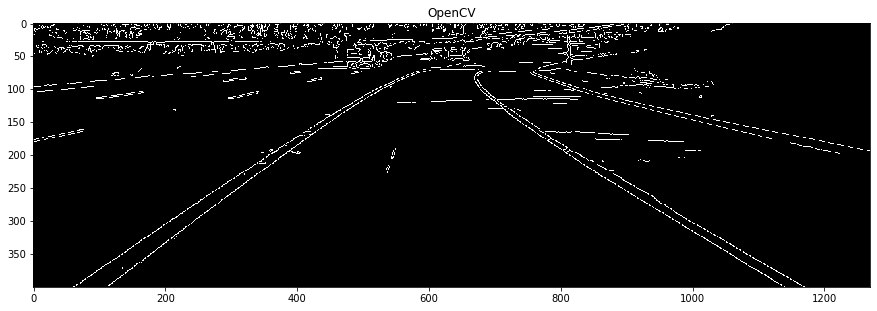

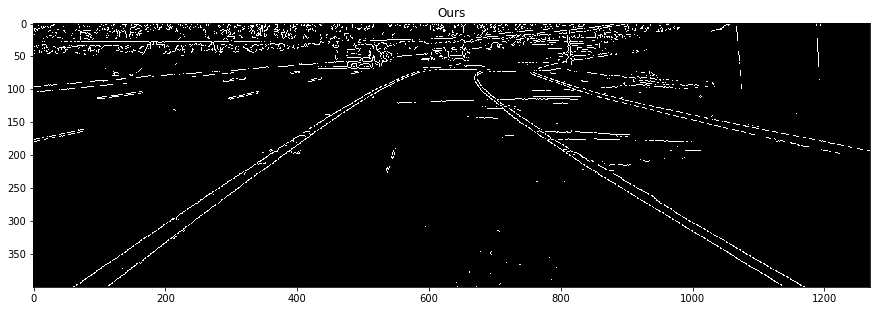

In [3]:
##########################################################################################################
##########################################################################################################
# Edge Detection Use OpenCV
img_edge_cv = cv.Canny(img_pruned,70,100, None,3)
plt.imshow(img_edge_cv)
plt.title('OpenCV')
plt.show()

##########################################################################################################
##########################################################################################################
# Edge Detection Use Our Canny Edge Detector
from functions import canny_edge_detector
low_thres = 8
high_thres = 10
kernel_size = 5
sigma = 1.4
img_edge = canny_edge_detector(img_pruned, kernel_size, sigma, high_thres, low_thres)
plt.imshow(img_edge)
plt.title('Ours')
plt.show()

### Part 4 - B-Spline and Canny/Hough Estimation of Vanishing Points

(94, 1, 4)
(56, 1, 4)


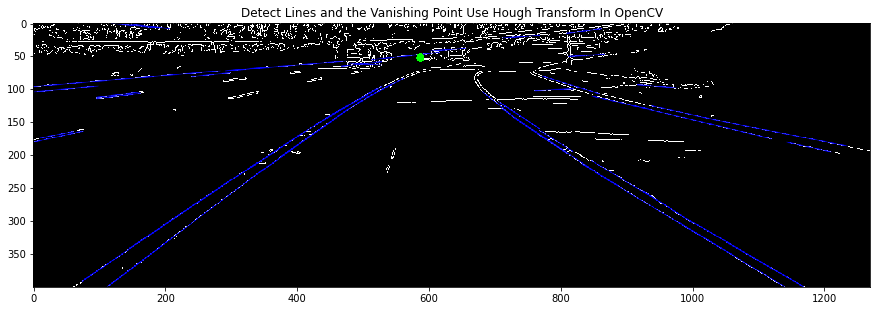

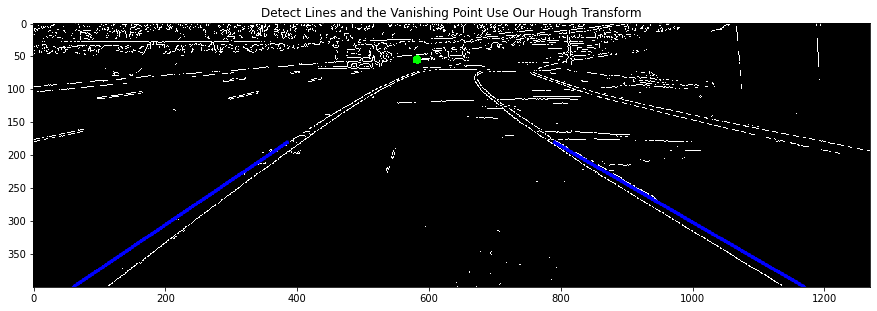

In [4]:
##########################################################################################################
##########################################################################################################
# Detect Lines and the Vanishing Point Use Hough Transform In OpenCV
img_dsp_cv = cv.cvtColor(img_edge_cv, cv.COLOR_GRAY2BGR) #for display only
#lines_Temp = cv.HoughLinesP(img_edge, 2, np.pi / 180, 40, None, 50, 10)
lines_Temp = cv.HoughLinesP(img_edge_cv, 1, 1 * np.pi / 180, 40, None, 50, 10)
lines = []

#print(lines_Temp.shape[0])
lines_Temp = np.array(lines_Temp)
print(lines_Temp.shape)
for i in range(lines_Temp.shape[0]):
    if abs((lines_Temp[i][0][3] - lines_Temp[i][0][1]) / (lines_Temp[i][0][2] - lines_Temp[i][0][0])) < 0.05:
        continue
    l = lines_Temp[i][0]
    cv.line(img_dsp_cv, (l[0], l[1]), (l[2], l[3]), (0,0,255),1, cv.LINE_AA)
    lines.append([l])

lines = np.array(lines)
print(lines.shape)
VP_cv = RANSAC_VP(lines)
#VPs.append(VP)

cv.circle(img_dsp_cv, (round(VP_cv[0]),round(VP_cv[1])), 3, (0,255,0), 5 )
#cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", img_dsp)
    
plt.imshow(img_dsp_cv)
plt.title('Detect Lines and the Vanishing Point Use Hough Transform In OpenCV')
plt.show()


##########################################################################################################
##########################################################################################################
# Detect Lines and the Vanishing Point Use Our Hough Transform
from functions import hough
VP_est, leftLane, rightLane, lines, numLeft, numRight = hough(img_edge, numLinesToFind = 20, onlyLeftAndRight = False)
#VP, leftLane, rightLane = hough(img_edge, numLinesToFind = 20, onlyLeftAndRight = True)
VP = RANSAC_VP(lines)

# Make a Copy of the edge map for visualization
img_edge_uint8 = img_edge.astype(np.uint8) * 255
img_dsp = cv.cvtColor(img_edge_uint8, cv.COLOR_GRAY2BGR) #for display only

cv.line(img_dsp, (leftLane[0][0], leftLane[0][1]), (leftLane[1][0], leftLane[1][1]), (0,0,255), 3, cv.LINE_AA)
cv.line(img_dsp, (rightLane[0][0], rightLane[0][1]), (rightLane[1][0], rightLane[1][1]), (0,0,255), 3, cv.LINE_AA)
#for line in lines:
#    cv.line(img_dsp, (round(line[0][0]), round(line[0][1])), 
#           (round(line[0][2]), round(line[0][3])), (0,0,255), 1, cv.LINE_AA)
cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
plt.imshow(img_dsp)
plt.title('Detect Lines and the Vanishing Point Use Our Hough Transform')
#plt.axis('off')
plt.show()

[312 242 184 135  91]
88
70
58
49
44


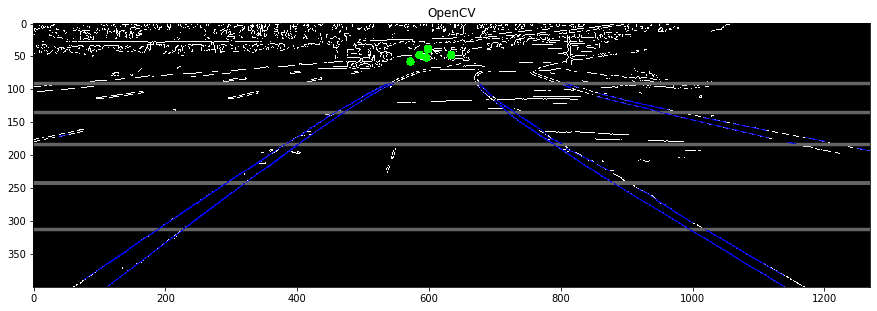

[312 243 186 136  93]
88
69
57
50
43


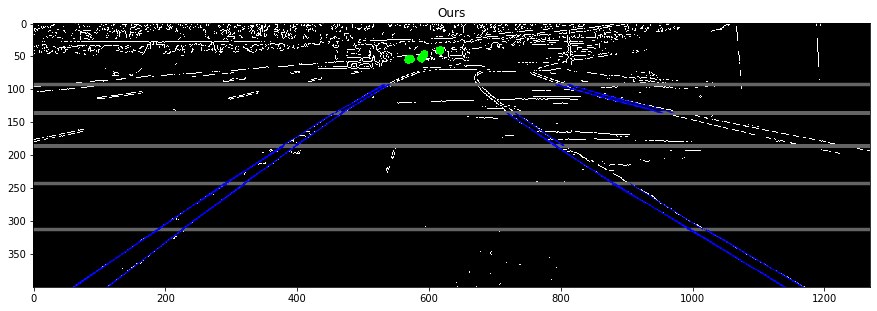

In [5]:
##########################################################################################################
##########################################################################################################
# OpenCV
VPs_cv = []
horizon_height = VP_cv[1]   
layer_cv = np.array([round((img_edge_cv.shape[0] - horizon_height) * (1/5 + 1/6 + 1/7 + 1/8 + 1/9) + horizon_height), 
                 round((img_edge_cv.shape[0]  - horizon_height) * (1/8 + 1/6 + 1/7 + 1/9) + horizon_height), 
                 round((img_edge_cv.shape[0]  - horizon_height) * (1/8 + 1/7 + 1/9) + horizon_height), 
                 round((img_edge_cv.shape[0]  - horizon_height) * (1/8 + 1/9) + horizon_height), 
                 round((img_edge_cv.shape[0]  - horizon_height) * (1/9) + horizon_height)])
print(layer_cv)
img_dsp_cv = cv.cvtColor(img_edge_cv, cv.COLOR_GRAY2BGR) #reinitiate display

for j in range(layer_cv.shape[0]):
    if(j != 0):
        curr_img = img_edge_cv[layer_cv[j]:layer_cv[j-1], :]
    else:
        curr_img = img_edge_cv[layer_cv[j]:, :]
    height = curr_img.shape[0]
    print(height)
    lines_Temp = cv.HoughLinesP(curr_img, 0.03, 0.03*np.pi / 180, round(height/7), None, round(height/5), max(round(height/10),5)) 
    
    
    lines=[]
    
    cv.line(img_dsp_cv, (0, layer_cv[j]), (img_edge_cv.shape[1], layer_cv[j]), (100,100,100),3, cv.LINE_AA)
    if lines_Temp is not None:
        for i in range(lines_Temp.shape[0]):
            if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.2:
                continue
            l = lines_Temp[i][0]

            cv.line(img_dsp_cv, (l[0], l[1]+layer_cv[j]), (l[2], l[3]+layer_cv[j]), (0,0,255),1, cv.LINE_AA)
            lines.append([l])

        lines = np.array(lines)
    VP_new_cv = RANSAC_VP(lines,VP[1]-50-layer_cv[j],VP[1]+50-layer_cv[j],VP[0]-150,VP[0]+150)
    if VP_new_cv[0]>0 or VP_new_cv[1]>0:
        VP_new_cv_ap = VP_new_cv
        VP_new_cv_ap[1] += layer_cv[j]
    VPs_cv.append(VP_new_cv_ap)
    cv.circle(img_dsp_cv, (round(VP_new_cv_ap[0]),round(VP_new_cv_ap[1])), 3, (0,255,0), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
VPs_cv = np.array(VPs_cv)
plt.imshow(img_dsp_cv)
plt.title('OpenCV')
plt.show()


##########################################################################################################
##########################################################################################################
# Our Implementation
VPs = []
horizon_height = VP[1]
layer = np.array([round((img_edge.shape[0] - horizon_height) * (1/5 + 1/6 + 1/7 + 1/8 + 1/9) + horizon_height), 
                  round((img_edge.shape[0] - horizon_height) * (1/8 + 1/6 + 1/7 + 1/9) + horizon_height), 
                  round((img_edge.shape[0] - horizon_height) * (1/8 + 1/7 + 1/9) + horizon_height), 
                  round((img_edge.shape[0] - horizon_height) * (1/8 + 1/9) + horizon_height), 
                  round((img_edge.shape[0] - horizon_height) * (1/9) + horizon_height)])
print(layer)
img_dsp = cv.cvtColor(img_edge_uint8, cv.COLOR_GRAY2BGR) #reinitiate display

VP_pre = VP.copy()
for j in range(layer.shape[0]):
    if(j != 0):
        curr_img = img_edge[layer[j]:layer[j-1], :]
    else:
        curr_img = img_edge[layer[j]:, :]
    height = curr_img.shape[0]
    cv.line(img_dsp, (0, layer[j]), (img_edge.shape[1], layer[j]), (100,100,100), 3, cv.LINE_AA)
    print(height)
    
    # Perform Hough Transform
    #VP_new, leftLane, rightLane = hough(curr_img, numLinesToFind = 10, onlyLeftAndRight = True)
    #VPs.append(VP_new)
    #cv.circle(img_dsp, (round(VP_new[0]),round(VP_new[1]+layer[j])), 3, (0,255,0), 5 )
    #cv.line(img_dsp, (leftLane[0][0], leftLane[0][1]+layer[j]), (leftLane[1][0], leftLane[1][1]+layer[j]), (0,0,255), 3, cv.LINE_AA)
    #cv.line(img_dsp, (rightLane[0][0], rightLane[0][1]+layer[j]), (rightLane[1][0], rightLane[1][1]+layer[j]), (0,0,255), 3, cv.LINE_AA)
    
    VP_est, leftLane, rightLane, lines, numLeft, numRight = hough(curr_img, numLinesToFind = 10, onlyLeftAndRight = False)
    if numRight / 5 > numLeft or numLeft / 5 > numRight:
        print("lol")
        VP_new = VP_est
    else:
        VP_RANSAC = RANSAC_VP(lines)
        if VP_RANSAC[0] > 0 or VP_RANSAC[1] > 0:
            VP_new = VP_RANSAC
    VP_new[1] += layer[j]
    if abs(VP_pre[0] - VP_new[0]) > 60 or abs(VP_pre[1] - VP_new[1]) > 60:
        print("haha")
        VP_new = VP_pre.copy()
    VP_pre = VP_new.copy()
    VPs.append(VP_new)
    cv.circle(img_dsp, (round(VP_new[0]),round(VP_new[1])), 3, (0,255,0), 5 )
    for line in lines:
        cv.line(img_dsp, (round(line[0][0]), round(line[0][1]+layer[j])), 
                (round(line[0][2]), round(line[0][3]+layer[j])), (0,0,255), 1, cv.LINE_AA)
    
VPs = np.array(VPs)
plt.imshow(img_dsp)
plt.title('Ours')
plt.show()


In [6]:
print(VPs)

[[571.63130903  54.28891611   1.        ]
 [568.55675463  54.9718012    1.        ]
 [588.80365583  53.27262249   1.        ]
 [592.67711451  46.81707815   1.        ]
 [616.81959418  40.86831425   1.        ]]


[618.86440678 312.           1.        ]
[613.83248205 242.           1.        ]
[605.43295309 184.           1.        ]
[601.79353419 135.           1.        ]
[617.85175361  91.           1.        ]
0.06968187415207484
0.4240768700069456


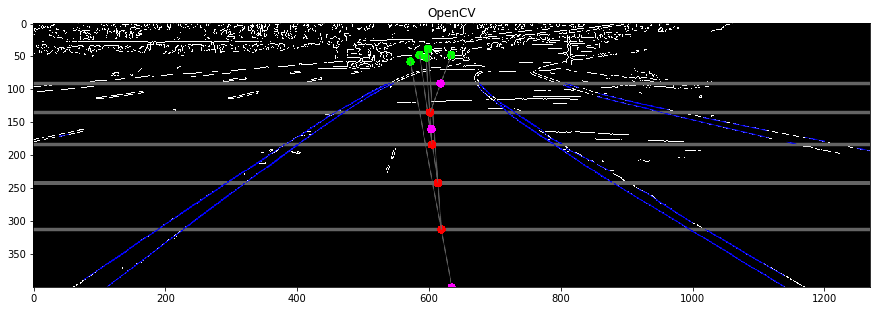

[618.86963836 312.           1.        ]
[605.36299203 243.           1.        ]
[600.38805285 186.           1.        ]
[597.6179794 136.          1.       ]
[606.29720577  93.           1.        ]
0.031714126259949564
0.2545114314627195


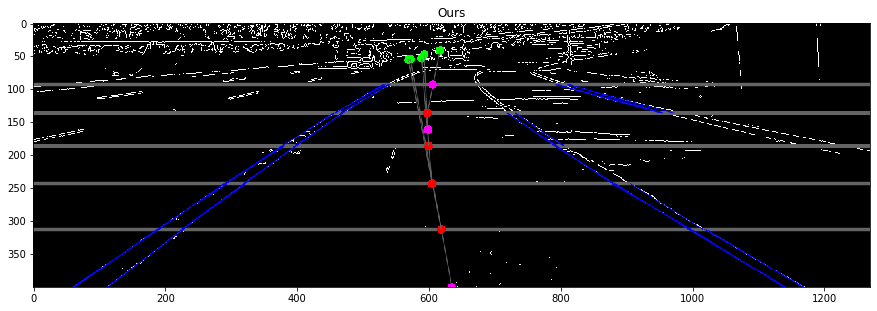

In [7]:
##########################################################################################################
##########################################################################################################
# OpenCV
Temp_Nodes_cv  = []
lower_bound = [round(img_edge_cv.shape[1] / 2), img_edge_cv.shape[0]]
Temp_Nodes_cv.append(lower_bound)
cv.circle(img_dsp_cv, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )
#cv.imshow("figure", img_dsp)
#cv.waitKey()

for i in range(layer_cv.shape[0]):
    line1 = [0 , 1, -layer_cv[i]]
    cv.line(img_dsp_cv, (round(lower_bound[0]), round(lower_bound[1])), 
            (round(VPs_cv[i,0]),round(VPs_cv[i,1])), (100,100,100), 1, cv.LINE_AA)
    line2 = [lower_bound[0], lower_bound[1], VPs_cv[i,0],VPs_cv[i,1] ]
    line2 = convert_homogenous_line(line2)
    lower_bound  = np.cross(line1, line2)
    lower_bound /= lower_bound[-1]
    Temp_Nodes_cv.append(lower_bound[0:2])
    print(lower_bound)
    cv.circle(img_dsp_cv, (round(lower_bound[0]), round(lower_bound[1])), 3, (255,0,0), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
    #This part need debugging the point correspondance might be wring

Nodes_cv = []

for i in range(3):
    Nodes_cv.append(Temp_Nodes_cv[0])
    
#node2=Temp_Nodes[0].copy()
#node2[1]=layer[0]#
#Nodes.append(node2)
    
l1 = Temp_Nodes_cv[-1] - Temp_Nodes_cv[-2]
l2 = Temp_Nodes_cv[-2] - Temp_Nodes_cv[-3]
l3 = Temp_Nodes_cv[-3] - Temp_Nodes_cv[-4]
b2 = Angle_btw_vect(l1, l2)#
b1 = Angle_btw_vect(l2, l3)#\
print(b1)
print(b2)

if(abs(b1)>=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes_cv.append((Temp_Nodes_cv[-3] + Temp_Nodes_cv[-2]) / 2)
elif(abs(b1)<=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes_cv.append(Temp_Nodes_cv[-2])#Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif(abs(b2)<=0.01): #check if
    Nodes_cv.append(Temp_Nodes_cv[-3])


for i in range(3):
    Nodes_cv.append(Temp_Nodes_cv[-1])
    
for Node in Nodes_cv:
    cv.circle(img_dsp_cv, (round(Node[0]),round(Node[1])), 3, (255,0,255), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
Nodes_cv = np.array(Nodes_cv)
plt.imshow(img_dsp_cv)
plt.title('OpenCV')
plt.show()


##########################################################################################################
##########################################################################################################
# Ours
Temp_Nodes  = []
lower_bound = [round(img_edge.shape[1] / 2), img_edge.shape[0]]
Temp_Nodes.append(lower_bound)
cv.circle(img_dsp, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )
#cv.imshow("figure", img_dsp)
#cv.waitKey()

for i in range(layer.shape[0]):
    line1=[0 , 1, -layer[i]]
    cv.line(img_dsp, (round(lower_bound[0]), round(lower_bound[1])), (round(VPs[i,0]),round(VPs[i,1])), (100,100,100), 1, cv.LINE_AA)
    line2 = [lower_bound[0], lower_bound[1], VPs[i,0],VPs[i,1] ]
    line2 = convert_homogenous_line(line2)
    lower_bound  = np.cross(line1, line2)
    lower_bound /= lower_bound[-1]
    Temp_Nodes.append(lower_bound[0:2])
    print(lower_bound)
    cv.circle(img_dsp, (round(lower_bound[0]), round(lower_bound[1])), 3, (255,0,0), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
    #This part need debugging the point correspondance might be wring

Nodes=[]

for i in range(3):
    Nodes.append(Temp_Nodes[0])
    
#node2=Temp_Nodes[0].copy()
#node2[1]=layer[0]#
#Nodes.append(node2)
    
l1 = Temp_Nodes[-1] - Temp_Nodes[-2]
l2 = Temp_Nodes[-2] - Temp_Nodes[-3]
l3 = Temp_Nodes[-3] - Temp_Nodes[-4]
b2 = Angle_btw_vect(l1, l2)#
b1 = Angle_btw_vect(l2, l3)#\
print(b1)
print(b2)

if(abs(b1)>=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append((Temp_Nodes[-3] + Temp_Nodes[-2]) / 2)
elif(abs(b1)<=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append(Temp_Nodes[-2])#Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif(abs(b2)<=0.01): #check if
    Nodes.append(Temp_Nodes[-3])


for i in range(3):
    Nodes.append(Temp_Nodes[-1])
    
for Node in Nodes:
    cv.circle(img_dsp, (round(Node[0]),round(Node[1])), 3, (255,0,255), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
Nodes = np.array(Nodes)
VPs = np.array(VPs)
plt.imshow(img_dsp)
plt.title('Ours')
plt.show()

C:\Users\Kaixinc\AppData\Local\Temp/ipykernel_18272/438104969.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  knotes=np.array(knotes)


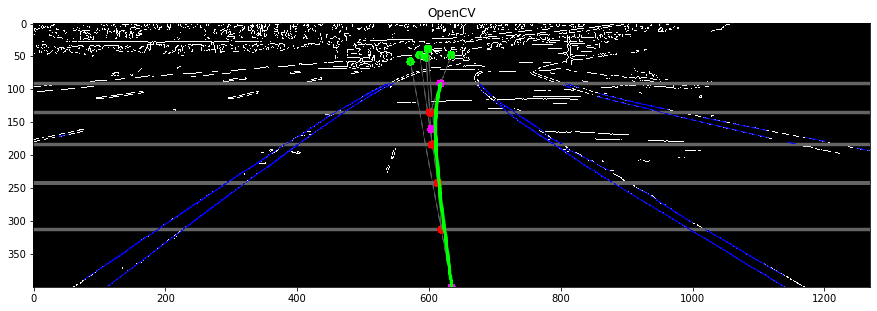

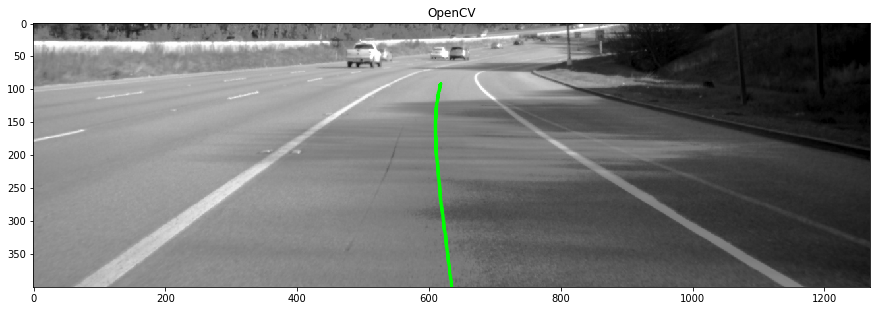

C:\Users\Kaixinc\AppData\Local\Temp/ipykernel_18272/438104969.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  knotes = np.array(knotes)


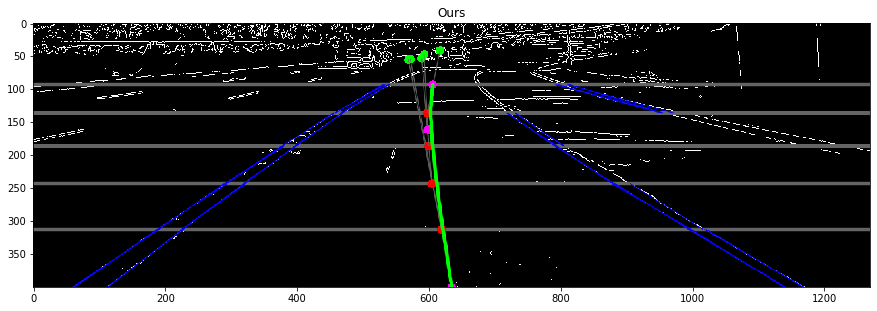

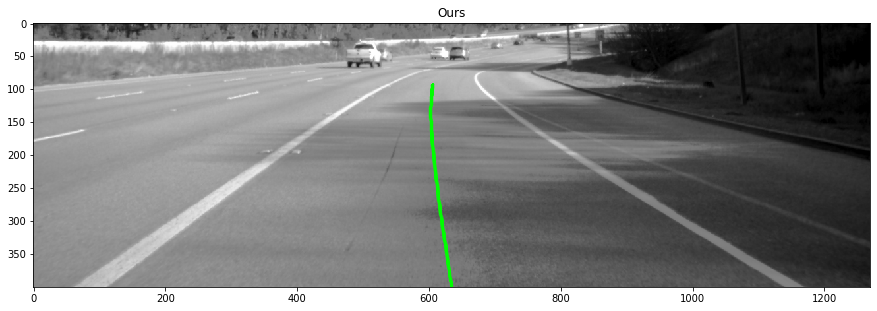

In [8]:
#The following code consulted the project https://github.com/kawache/Python-B-spline-examples
##########################################################################################################
##########################################################################################################
# OpenCV
from scipy import interpolate 
x = Nodes_cv[:,0]
y = Nodes_cv[:,1]
len = Nodes_cv.shape[0]
knote = np.linspace(0,1,len-2,endpoint=True)


knote=np.hstack([[0,0,0],knote])
knote=np.hstack([knote,[1,1,1]])

knotes =[knote,np.array([x,y]),3]
knotes=np.array(knotes)

u=np.linspace(0,1,(max(len*2,70)),endpoint=True)
ans = interpolate.splev(u,knotes)
ans=np.array(ans)

for i in range(ans.shape[1]-1):
    cv.line(img_dsp_cv, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
plt.imshow(img_dsp_cv)
plt.title('OpenCV')
plt.show()

img_dsp2_cv = cv.cvtColor(img_pruned, cv.COLOR_GRAY2BGR)
for i in range(ans.shape[1]-1):
    cv.line(img_dsp2_cv, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
#cv.imshow("figure", img_dsp2)
#cv.waitKey()
plt.imshow(img_dsp2_cv)
plt.title('OpenCV')
plt.show()

##########################################################################################################
##########################################################################################################
# Ours
from scipy import interpolate 
x = Nodes[:,0]
y = Nodes[:,1]
len = Nodes.shape[0]
knote = np.linspace(0, 1, len-2, endpoint=True)

knote = np.hstack([[0,0,0],knote])
knote = np.hstack([knote,[1,1,1]])

knotes = [knote,np.array([x,y]),3]
knotes = np.array(knotes)

u   = np.linspace(0,1,(max(len*2,70)),endpoint=True)
ans = interpolate.splev(u,knotes)
ans = np.array(ans)

for i in range(ans.shape[1]-1):
    cv.line(img_dsp, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
plt.imshow(img_dsp)
plt.title('Ours')
plt.show()

img_dsp2 = cv.cvtColor(img_pruned, cv.COLOR_GRAY2BGR)
for i in range(ans.shape[1]-1):
    cv.line(img_dsp2, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
#cv.imshow("figure", img_dsp2)
#cv.waitKey()
plt.imshow(img_dsp2)
plt.title('Ours')
plt.show()

In [9]:
'''
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #for display only
#lines_Temp = cv.HoughLinesP(img_edge, 2, np.pi / 180, 40, None, 50, 10)
lines_Temp = cv.HoughLinesP(img_edge, 1, 1 * np.pi / 180, 40, None, 50, 10)
lines=[]
VPs=[]

#print(lines_Temp.shape[0])
lines_Temp=np.array(lines_Temp)
for i in range(lines_Temp.shape[0]):
    if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:
        continue
    l = lines_Temp[i][0]
    cv.line(img_dsp, (l[0], l[1]), (l[2], l[3]), (0,0,255),1, cv.LINE_AA)
    lines.append([l])
    
lines=np.array(lines)
VP=RANSAC_VP(lines)
#VPs.append(VP)

cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
#cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", img_dsp)

#cv.waitKey()

horizon_height=VP[1]

#layer= np.array([round((img_edge.shape[0]-horizon_height)*11/16+horizon_height),round((img_edge.shape[0]-horizon_height)*(7/16)+horizon_height), round((img_edge.shape[0]-horizon_height)*(3/16)+horizon_height),round(horizon_height)])
#1/5+1/6+1/7+1/8   1/6+1/7+1/8  1/7+1/8 1/8    
layer= np.array([round((img_edge.shape[0]-horizon_height)*(1/5+1/6+1/7 +1/8  +1/9)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/8+1/6+1/7 +1/9)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/7 +1/9)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/9)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/9)+horizon_height)])
#layer= np.array([round((img_edge.shape[0]-horizon_height)*(1/5+1/6+1/7 +1/8  +1/30)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/8+1/6+1/7 +1/30)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/7 +1/30)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/30)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/30)+horizon_height)])
print(layer)
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #reinitiate display

for j in range(layer.shape[0]):
    if(j!= 0):
        curr_img=img_edge[layer[j]:layer[j-1],:]
    else:
        curr_img=img_edge[layer[j]:,:]
    height=curr_img.shape[0]
    print(height)
    #lines_Temp = cv.HoughLinesP(curr_img, 2, np.pi / 180, 30, None, 50, 10)
    #lines_Temp = cv.HoughLinesP(curr_img, 4, 2*np.pi / 180, round(height/5), None, round(height/3), round(height/15)) #first worked
    #lines_Temp = cv.HoughLinesP(curr_img, 0.5, 0.5*np.pi / 180, round(height/5), None, round(height/3.7), max(round(height/13),4)) #worked well
    lines_Temp = cv.HoughLinesP(curr_img, 0.03, 0.03*np.pi / 180, round(height/7), None, round(height/5), max(round(height/10),5)) 
    
    
    lines=[]
    
    cv.line(img_dsp, ( 0,layer[j]), (    img_edge.shape[1],layer[j]   ), (100,100,100),3, cv.LINE_AA)
    if lines_Temp is not None:
        for i in range(lines_Temp.shape[0]):
            if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.2:
                continue
            l = lines_Temp[i][0]

            cv.line(img_dsp, (l[0], l[1]+layer[j]), (l[2], l[3]+layer[j]), (0,0,255),1, cv.LINE_AA)
            lines.append([l])

        lines=np.array(lines)
    VP_new=RANSAC_VP(lines,VP[1]-50-layer[j],VP[1]+50-layer[j],VP[0]-150,VP[0]+150)
    if VP_new[0]>0 or VP_new[1]>0:
        VP=VP_new
        VP[1]+=layer[j]
    VPs.append(VP)
    cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
   
VPs=np.array(VPs)
'''

'\nimg_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #for display only\n#lines_Temp = cv.HoughLinesP(img_edge, 2, np.pi / 180, 40, None, 50, 10)\nlines_Temp = cv.HoughLinesP(img_edge, 1, 1 * np.pi / 180, 40, None, 50, 10)\nlines=[]\nVPs=[]\n\n#print(lines_Temp.shape[0])\nlines_Temp=np.array(lines_Temp)\nfor i in range(lines_Temp.shape[0]):\n    if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:\n        continue\n    l = lines_Temp[i][0]\n    cv.line(img_dsp, (l[0], l[1]), (l[2], l[3]), (0,0,255),1, cv.LINE_AA)\n    lines.append([l])\n    \nlines=np.array(lines)\nVP=RANSAC_VP(lines)\n#VPs.append(VP)\n\ncv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )\n#cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", img_dsp)\n\n#cv.waitKey()\n\nhorizon_height=VP[1]\n\n#layer= np.array([round((img_edge.shape[0]-horizon_height)*11/16+horizon_height),round((img_edge.shape[0]-horizon_height)*(7/16)+horizon_height), round((im

In [10]:
'''
Temp_Nodes=[]
lower_bound=[round(img_edge.shape[1]/2), img_edge.shape[0]]
Temp_Nodes.append(lower_bound)
cv.circle(img_dsp, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )
#cv.imshow("figure", img_dsp)
#cv.waitKey()

for i in  range( np.shape(layer)[0]):
    line1=[0 , 1, -layer[i]]
    cv.line(img_dsp, (round(lower_bound[0]),round( lower_bound[1])), (    round(VPs[i,0]),round(VPs[i,1])   ), (100,100,100),1, cv.LINE_AA)
    line2=[lower_bound[0], lower_bound[1], VPs[i,0],VPs[i,1] ]
    line2 = convert_homogenous_line(line2)
    lower_bound= np.cross(line1, line2)
    lower_bound/=lower_bound[-1]
    Temp_Nodes.append(lower_bound[0:2])
    print(lower_bound)
    cv.circle(img_dsp, (round(lower_bound[0]),round(lower_bound[1])), 3, (255,0,0), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
    #This part need debugging the point correspondance might be wring

Nodes=[]

for i in range(3):
    Nodes.append(Temp_Nodes[0])
    
#node2=Temp_Nodes[0].copy()
#node2[1]=layer[0]#
#Nodes.append(node2)
    
l1= Temp_Nodes[-1]-Temp_Nodes[-2]
l2= Temp_Nodes[-2]-Temp_Nodes[-3]
l3= Temp_Nodes[-3]-Temp_Nodes[-4]
b2= Angle_btw_vect(l1, l2)#
b1= Angle_btw_vect(l2, l3)#\
print(b1)
print(b2)

if(abs(b1)>=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif(abs(b1)<=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append(Temp_Nodes[-2])#Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif(  abs(b2)<=0.01 ): #check if
    Nodes.append(Temp_Nodes[-3])


for i in range(3):
    Nodes.append(Temp_Nodes[-1])
    
for Node in Nodes:
    cv.circle(img_dsp, (round(Node[0]),round(Node[1])), 3, (255,0,255), 5 )
    #cv.imshow("figure", img_dsp)
    #cv.waitKey()
    
Nodes=np.array(Nodes)
'''

'\nTemp_Nodes=[]\nlower_bound=[round(img_edge.shape[1]/2), img_edge.shape[0]]\nTemp_Nodes.append(lower_bound)\ncv.circle(img_dsp, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )\n#cv.imshow("figure", img_dsp)\n#cv.waitKey()\n\nfor i in  range( np.shape(layer)[0]):\n    line1=[0 , 1, -layer[i]]\n    cv.line(img_dsp, (round(lower_bound[0]),round( lower_bound[1])), (    round(VPs[i,0]),round(VPs[i,1])   ), (100,100,100),1, cv.LINE_AA)\n    line2=[lower_bound[0], lower_bound[1], VPs[i,0],VPs[i,1] ]\n    line2 = convert_homogenous_line(line2)\n    lower_bound= np.cross(line1, line2)\n    lower_bound/=lower_bound[-1]\n    Temp_Nodes.append(lower_bound[0:2])\n    print(lower_bound)\n    cv.circle(img_dsp, (round(lower_bound[0]),round(lower_bound[1])), 3, (255,0,0), 5 )\n    #cv.imshow("figure", img_dsp)\n    #cv.waitKey()\n    \n    #This part need debugging the point correspondance might be wring\n\nNodes=[]\n\nfor i in range(3):\n    Nodes.append(Temp_Nodes[0])\n    \n#node2=Temp_Nodes[0

In [11]:
'''
#The following code consulted the project https://github.com/kawache/Python-B-spline-examples
from scipy import interpolate 
x=Nodes[:,0]
y=Nodes[:,1]
len=Nodes.shape[0]
knote=np.linspace(0,1,len-2,endpoint=True)


knote=np.hstack([[0,0,0],knote])
knote=np.hstack([knote,[1,1,1]])

knotes =[knote,np.array([x,y]),3]
knotes=np.array(knotes)

u=np.linspace(0,1,(max(len*2,70)),endpoint=True)
ans = interpolate.splev(u,knotes)
ans=np.array(ans)

for i in range(ans.shape[1]-1):
    cv.line(img_dsp, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
cv.imshow("figure", img_dsp)
cv.waitKey()

img_dsp2=cv.cvtColor(img_pruned,cv.COLOR_GRAY2BGR)
for i in range(ans.shape[1]-1):
    cv.line(img_dsp2, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
cv.imshow("figure", img_dsp2)
cv.waitKey()
'''

'\n#The following code consulted the project https://github.com/kawache/Python-B-spline-examples\nfrom scipy import interpolate \nx=Nodes[:,0]\ny=Nodes[:,1]\nlen=Nodes.shape[0]\nknote=np.linspace(0,1,len-2,endpoint=True)\n\n\nknote=np.hstack([[0,0,0],knote])\nknote=np.hstack([knote,[1,1,1]])\n\nknotes =[knote,np.array([x,y]),3]\nknotes=np.array(knotes)\n\nu=np.linspace(0,1,(max(len*2,70)),endpoint=True)\nans = interpolate.splev(u,knotes)\nans=np.array(ans)\n\nfor i in range(ans.shape[1]-1):\n    cv.line(img_dsp, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3\n            , cv.LINE_AA)\ncv.imshow("figure", img_dsp)\ncv.waitKey()\n\nimg_dsp2=cv.cvtColor(img_pruned,cv.COLOR_GRAY2BGR)\nfor i in range(ans.shape[1]-1):\n    cv.line(img_dsp2, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3\n            , cv.LINE_AA)\ncv.imshow("figure", img_dsp2)\ncv.waitKey()\n'

In [12]:
'''
from scipy import interpolate

Nodes=np.array(Nodes)
plt.imshow(img_dsp)
print(Nodes)

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


nodes = np.array( [ [1, 2], [6, 15], [10, 6], [10, 3], [3, 7] ] )

x = nodes[:,0]
y = nodes[:,1]

tck,u     = interpolate.splprep( [x,y] ,s = 0 )
xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

plt.plot( x,y,'o' , xnew ,ynew )
plt.legend( [ 'data' , 'spline'] )
plt.axis( [ x.min() - 1 , x.max() + 1 , y.min() - 1 , y.max() + 2 ] )
plt.show()
'''

"\nfrom scipy import interpolate\n\nNodes=np.array(Nodes)\nplt.imshow(img_dsp)\nprint(Nodes)\n\nfrom __future__ import division\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy import interpolate\n\n\nnodes = np.array( [ [1, 2], [6, 15], [10, 6], [10, 3], [3, 7] ] )\n\nx = nodes[:,0]\ny = nodes[:,1]\n\ntck,u     = interpolate.splprep( [x,y] ,s = 0 )\nxnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)\n\nplt.plot( x,y,'o' , xnew ,ynew )\nplt.legend( [ 'data' , 'spline'] )\nplt.axis( [ x.min() - 1 , x.max() + 1 , y.min() - 1 , y.max() + 2 ] )\nplt.show()\n"